In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -----------------------------
# 1. Load MSNIST dataset
# -----------------------------

# This will stream the data, you don't have to download the full file
# mnist_train = load_dataset("ylecun/mnist", split="train")

# mnist_test = load_dataset("ylecun/mnist", split="test")


##### Look into the normalisation #####
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_train = datasets.MNIST("./data", train=True, download=False, transform=transform)

mnist_test = datasets.MNIST("./data", train=False, download=False, transform=transform)

In [32]:
def stitch_images(images, grid_size):
    """
    images: Tensor of shape (n, 1, 28, 28)
    grid_size: int, e.g., 2 or 3
    Returns: Tensor of shape (1, 28*grid_size, 28*grid_size)
    """
    assert images.shape[0] == grid_size**2
    # Remove the channel dimension for concatenation
    images = images.squeeze(1)  # Now shape: (n, 28, 28)
    rows = []
    for i in range(grid_size):
        row = torch.cat([images[i * grid_size + j] for j in range(grid_size)], dim=1)
        rows.append(row)
    stitched = torch.cat(rows, dim=0)  # Shape: (28*grid_size, 28*grid_size)
    return stitched.unsqueeze(0)       # Shape: (1, 28*grid_size, 28*grid_size)

def sample_random_images(dataset, num):
    idxs = random.sample(range(len(dataset)), num)
    imgs = []
    for i in idxs:
        img, _ = dataset[i]  # img: (1, 28, 28)
        imgs.append(img)
    return torch.stack(imgs)

In [33]:
def patch(img, patch_size=7):
    # img shape: (1, 28, 28)
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    # shape: (1, 4, 4, 7, 7)
    patches = patches.contiguous().view(1, -1, patch_size, patch_size)
    # shape: (1, 16, 7, 7)
    return patches.squeeze(0)  # (16, 7, 7)


(-0.5, 83.5, 83.5, -0.5)

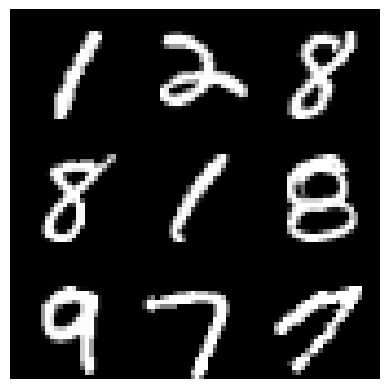

In [53]:
# Build stitched image (make sure grid_size*28 divisible by 7)
grid_size = 3
imgs = sample_random_images(mnist_train, grid_size**2)         # (4, 1, 28, 28)
stitched = stitch_images(imgs, grid_size)                      # (1, 56, 56)
plt.imshow(stitched.squeeze(), cmap='gray')
plt.axis('off')

torch.Size([1, 56, 56])


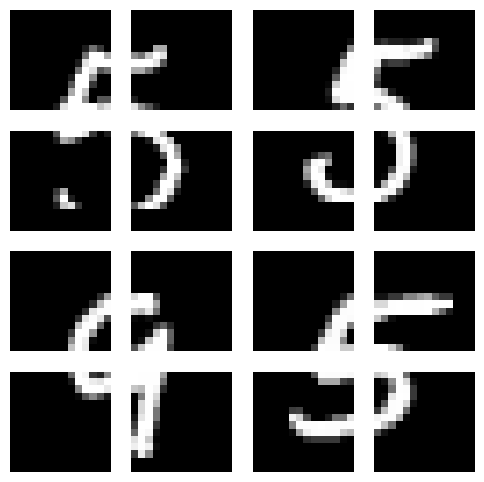

In [50]:
print(stitched.shape)  # Should be (1, 56, 56)
patches = patch(stitched, patch_size=14) 

num_patches = patches.shape[0]
side = int(num_patches ** 0.5)

fig, axes = plt.subplots(side, side, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(patches[i], cmap='gray')
    ax.axis('off')
